## Preparation

We start by installing the packages we need.

Import packages.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Data preparation

## Exploratory Data Analysis

We now plot our weekly data.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import talib

real_df = pd.read_table('/projects/genomic-ml/da2343/ml_project_2/robust_algo_trader/data/EURUSD_H1_200702210000_202304242100.tsv')
# real_df = pd.read_table('/Users/newuser/Projects/robust-algo-trader/data/EURUSD_H1_202302010000_202304242100.tsv')

df = real_df.copy()
# take only last 7000 rows
df = df.iloc[-(200+24*7*4):]
# df = df.iloc[-(24*7*3):]
# df = df.iloc[-(24*5):]
# df = df.iloc[-120:]
# remove the following columns <TICKVOL>, <VOL> and <SPREAD>
df = df.drop(['<TICKVOL>', '<VOL>', '<SPREAD>'], axis=1)
df = df.rename(columns={'<DATE>': 'Date', 
                                '<TIME>': 'Time', 
                                '<OPEN>': 'Open', 
                                '<HIGH>': 'High', 
                                '<LOW>': 'Low', 
                                '<CLOSE>': 'Close'
                                })
# combine the date and time columns
df['Date_Time'] = df['Date'] + ' ' + df['Time']
# remove the date and time columns
df = df.drop(['Date', 'Time'], axis=1)
# convert the date_time column to datetime
df['Time'] = pd.to_datetime(df['Date_Time'])
# Rename Date_Time to Time
# df.index = df['Time']
# df.set_index("Time")
# remove the Time column
df = df.drop(['Time'], axis=1)

prices = df["Close"].values
df["SMA"] = talib.SMA(prices, timeperiod=200)
df = df.dropna()

In [ ]:
df

In [ ]:
from sklearn.cluster import KMeans

close_df = df[['Close']]

# reshape the data into a 2D array
X = close_df.values.reshape(-1,1)

# choose the number of clusters (you can use other methods to find the optimal number)
k = 10

# create and fit the k means model
model = KMeans(n_clusters=k, random_state=0, n_init = 100, max_iter = 1000)
model.fit(X)

# get the cluster labels and centroids
labels = model.labels_
centroids = model.cluster_centers_

# assign the labels and centroids to the dataframe
df['Label'] = labels
df['Centroid'] = df['Label'].apply(lambda x: centroids[x])

# plot the data with the clusters and centroids
plt.figure(figsize=(10,6))
plt.plot(df['Close'], label='Price')
# plt.plot(df['Centroid'], label='Centroid')
plt.scatter(df.index, df['Centroid'], c=df['Label'], cmap='rainbow', marker='o', s=50, alpha=0.5, label='Cluster')
plt.title(f'Support and Resistance Levels using K-Means Clustering')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

In [ ]:
# Import libraries
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans

# Define MACD parameters
short_ema = 12
long_ema = 26
signal_ema = 9


# Calculate MACD and signal lines
df["EMA_short"] = df["Close"].ewm(span=short_ema, adjust=False).mean()
df["EMA_long"] = df["Close"].ewm(span=long_ema, adjust=False).mean()
df["MACD"] = df["EMA_short"] - df["EMA_long"]
df["Signal"] = df["MACD"].ewm(span=signal_ema, adjust=False).mean()

# Find MACD crossovers
df["Crossover"] = np.where(df["MACD"] > df["Signal"], 1, -1)
df["Crossover_change"] = df["Crossover"].diff()
df = df.dropna()
df = df.reset_index(drop=True)

In [ ]:
df 

In [ ]:


# Define K-means parameters
n_clusters = 7 # Number of clusters for TP and SL levels
random_state = 42 # Random seed for reproducibility

# Initialize an empty numpy array of dictionaries
orders = np.array([])

# Loop through the rows of the dataframe
for i in range(len(df)):
    # If there is a MACD crossover
    if df.loc[i, "Crossover_change"] != 0:
        # Get the ask price
        ask_price = df.loc[i, "Close"]
        # Get the position (buy or sell)
        position = "Buy" if df.loc[i, "Crossover_change"] == 2 else "Sell"
        # Get the next n rows of price data
        next_prices = df.loc[i+1:i+n_clusters, "Close"].values.reshape(-1, 1)
        # Fit K-means on the next prices
        kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, n_init='auto').fit(next_prices)
        # Get the cluster centers as the TP and SL levels
        tp_sl_levels = kmeans.cluster_centers_.flatten()
        # Sort the levels in ascending order
        tp_sl_levels.sort()
        # If the position is buy, the highest level is the TP and the lowest level is the SL
        # If the position is sell, the lowest level is the TP and the highest level is the SL
        tp_level = tp_sl_levels[-1] if position == "Buy" else tp_sl_levels[0]
        sl_level = tp_sl_levels[0] if position == "Buy" else tp_sl_levels[-1]
        # Calculate the TP and SL ratios
        tp_ratio = abs(tp_level - ask_price) / ask_price
        sl_ratio = abs(sl_level - ask_price) / ask_price
        # Check if the TP ratio is greater than the SL ratio
        if tp_ratio > sl_ratio:
            # Create a dictionary with the order details
            order = {"ask_price": ask_price,
                     "take_profit_price": tp_level,
                     "stop_loss_price": sl_level,
                     "position": position,
                     }
            # Append the dictionary to the numpy array
            orders = np.append(orders, order)

# Print the numpy array of dictionaries
print(orders)


In [45]:
len(orders)

22

In [46]:
len(outcomes)

22

In [47]:
print(orders)


[{'ask_price': 1.06337, 'take_profit_price': 1.06628, 'stop_loss_price': 1.06402, 'position': 'Buy'}
 {'ask_price': 1.0707, 'take_profit_price': 1.07269, 'stop_loss_price': 1.07052, 'position': 'Buy'}
 {'ask_price': 1.07225, 'take_profit_price': 1.07122, 'stop_loss_price': 1.07221, 'position': 'Sell'}
 {'ask_price': 1.07632, 'take_profit_price': 1.07813, 'stop_loss_price': 1.07643, 'position': 'Buy'}
 {'ask_price': 1.07972, 'take_profit_price': 1.08808, 'stop_loss_price': 1.07815, 'position': 'Buy'}
 {'ask_price': 1.07989, 'take_profit_price': 1.08808, 'stop_loss_price': 1.07935, 'position': 'Buy'}
 {'ask_price': 1.08858, 'take_profit_price': 1.08734, 'stop_loss_price': 1.08956, 'position': 'Sell'}
 {'ask_price': 1.0759, 'take_profit_price': 1.07778, 'stop_loss_price': 1.07601, 'position': 'Buy'}
 {'ask_price': 1.08412, 'take_profit_price': 1.08321, 'stop_loss_price': 1.08471, 'position': 'Sell'}
 {'ask_price': 1.0855, 'take_profit_price': 1.09171, 'stop_loss_price': 1.08606, 'position

In [44]:
# Import libraries
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score

# Load price data
# Initialize an empty list to store the trade outcomes
outcomes = []

# Loop through the orders array
for order in orders:
    # Get the order details
    ask_price = order["ask_price"]
    tp_price = order["take_profit_price"]
    sl_price = order["stop_loss_price"]
    position = order["position"]
    # Find the index of the row where the ask price matches the close price in the dataframe
    index = df.index[df["Close"] == ask_price][0]
    # Get the next n rows of price data from the close column of the dataframe, where n is equal to the number of clusters
    next_prices = df.loc[index+1:index+n_clusters, "Close"].values
    # Initialize a variable to store the trade outcome
    outcome = None
    # Loop through the next prices
    for price in next_prices:
        # If the position is buy, check if the price reaches the TP or SL level
        if position == "Buy":
            # If the price is greater than or equal to the TP level, set the outcome to 1 and break the loop
            if price >= tp_price:
                outcome = 1
                break
            # If the price is less than or equal to the SL level, set the outcome to 0 and break the loop
            elif price <= sl_price:
                outcome = 0
                break
        # If the position is sell, check if the price reaches the TP or SL level
        elif position == "Sell":
            # If the price is less than or equal to the TP level, set the outcome to 1 and break the loop
            if price <= tp_price:
                outcome = 1
                break
            # If the price is greater than or equal to the SL level, set the outcome to 0 and break the loop
            elif price >= sl_price:
                outcome = 0
                break
    # If none of the prices reach the TP or SL level, set the outcome to None
    if outcome is None:
        outcome = None
    # Append the outcome to the outcomes list
    outcomes.append(outcome)
# Convert the outcomes list to a numpy array
outcomes = np.array(outcomes)
# Print the outcomes array
print(outcomes)

y_pred = outcomes
y_true = outcomes


[0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0]


In [43]:
from sklearn.metrics import accuracy_score

# Calculate accuracy score 
accuracy = accuracy_score(y_true, y_pred)
print("Accuracy:", accuracy)

Accuracy: 1.0


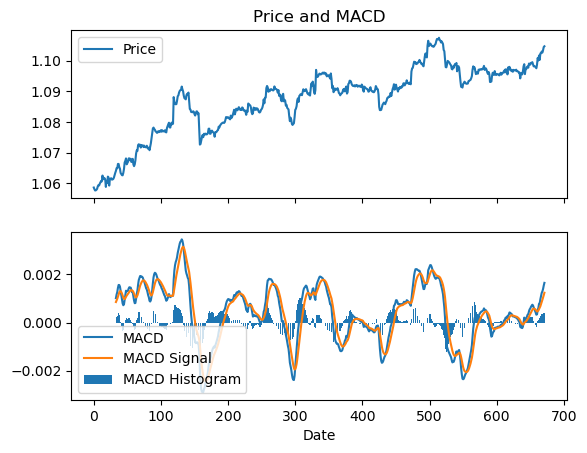

In [48]:
# import libraries
import talib
import matplotlib.pyplot as plt

# assume you have the price data in a pandas dataframe called df
# calculate the macd, macdsignal and macdhist values
macd, macdsignal, macdhist = talib.MACD(df['Close'])

# create a figure and two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

# plot the price data on the first subplot
ax1.plot(df['Close'], label='Price')
ax1.set_title('Price and MACD')
ax1.legend()

# plot the macd, macdsignal and macdhist values on the second subplot
ax2.plot(macd, label='MACD')
ax2.plot(macdsignal, label='MACD Signal')
ax2.bar(df.index, macdhist, label='MACD Histogram')
ax2.set_xlabel('Date')
ax2.legend()

# show the figure
plt.show()


In [ ]:
import yfinance as yf
import mplfinance as mpf
import talib as ta

ticker_name = 'MSFT'
yticker = yf.Ticker("MSFT")
data = yticker.history(period="1y") # max, 1y, 3mo
# trim volume to avoid exponential form
data['Volume'] = data['Volume'] / 1000
# macd
data["macd"], data["macd_signal"], data["macd_hist"] = ta.MACD(data['Close'])
# macd panel
colors = ['g' if v >= 0 else 'r' for v in data["macd_hist"]]
macd_plot = mpf.make_addplot(data["macd"], panel=1, color='fuchsia', title="MACD")
macd_hist_plot = mpf.make_addplot(data["macd_hist"], type='bar', panel=1, color=colors) # color='dimgray'
macd_signal_plot = mpf.make_addplot(data["macd_signal"], panel=1, color='b')
# plot
plots = [macd_plot, macd_signal_plot, macd_hist_plot]
mpf.plot(data, type='candle', style='yahoo', mav=(50,100,200), addplot=plots, title=f"\n{ticker_name}", volume=True, volume_panel=2, ylabel='', ylabel_lower='')

In [ ]:
y = df[['SMA']]

In [ ]:
len(y)

In [ ]:
from sktime.utils.plotting import plot_series
plot_series(y)

## Forecasting

### Multiple Linear Regression

In [ ]:
len(y)

In [ ]:
from sktime.forecasting.model_selection import temporal_train_test_split
y_train, y_test = temporal_train_test_split(y, test_size=24*7) # Predict from 1st July 2019

In [ ]:
type(y_train)

In [ ]:
from sktime.forecasting.base import ForecastingHorizon
from sklearn.linear_model import LinearRegression, LassoCV
from sktime.forecasting.compose import make_reduction
from sktime.utils.plotting import plot_series
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error

regressor = LinearRegression()
forecaster = make_reduction(regressor, window_length=120, strategy="recursive")
forecaster.fit(y_train)
fh = ForecastingHorizon(y_test.index, is_relative=False)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"], x_label='Date', y_label='SMA')

print('MAPE: %.6f' % mean_absolute_percentage_error(y_test, y_pred, symmetric=False))

In [ ]:
MAPE: 0.000414

In [ ]:
from sktime.datasets import load_airline
from sktime.forecasting.trend import TrendForecaster

forecaster = TrendForecaster()
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"], x_label='Date', y_label='SMA')
print('MAPE: %.4f' % mean_absolute_percentage_error(y_test, y_pred, symmetric=False))

In [ ]:
y_pred

In [ ]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing

forecaster = ExponentialSmoothing(trend="add", seasonal="additive", sp=12)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_test, y_pred, symmetric=False)

### XGBoost with multiple inputs

### Tuning the hyperparameters of our forecaster

In [ ]:
from sktime.forecasting.model_selection import SingleWindowSplitter, ForecastingRandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(random_state=1)
forecaster = make_reduction(regressor, window_length=52, strategy="recursive")
gscv = ForecastingRandomizedSearchCV(forecaster, 
                                     cv=SlidingWindowSplitter(window_length=len(y_train)-26, fh=26), param_distributions= {
                                        'deseasonalize__model': ['multiplicative', 'additive'],
                                        'detrend__forecaster__degree': [1, 2, 3],
                                        'forecast__estimator__max_depth': [3, 5, 6, 10, 15, 20],
                                        'forecast__estimator__learning_rate': [0.01, 0.1, 0.2, 0.3],
                                        'forecast__estimator__subsample': np.arange(0.5, 1.0, 0.1),
                                        'forecast__estimator__colsample_bytree': np.arange(0.4, 1.0, 0.1),
                                        'forecast__estimator__colsample_bylevel': np.arange(0.4, 1.0, 0.1),
                                        'forecast__estimator__n_estimators': [100, 500, 1000],
                                    }, 
                                     n_iter=1_00, 
                                     random_state=1)

forecaster.fit(y_train)
y_pred = gscv.predict(fh)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_test, y_pred, symmetric=False)

In [ ]:
gscv.cv_results_

## Adding components to our forecasting pipeline

In [ ]:
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.transformations.series.detrend import Deseasonalizer, Detrender
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.forecasting.model_selection import SingleWindowSplitter, SlidingWindowSplitter
from sktime.forecasting.model_selection import ForecastingRandomizedSearchCV

regressor = XGBRegressor(objective='reg:squarederror', random_state=1)

forecaster = TransformedTargetForecaster(
    [
        ("deseasonalize", Deseasonalizer(model="multiplicative", sp=52)),
        ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=1))),
        ("forecast", make_reduction(regressor, window_length=52, strategy="recursive")),
    ]
)

param_grid = {
    'deseasonalize__model': ['multiplicative', 'additive'],
    'detrend__forecaster__degree': [1, 2, 3],
    'forecast__estimator__max_depth': [3, 5, 6, 10, 15, 20],
    'forecast__estimator__learning_rate': [0.01, 0.1, 0.2, 0.3],
    'forecast__estimator__subsample': np.arange(0.5, 1.0, 0.1),
    'forecast__estimator__colsample_bytree': np.arange(0.4, 1.0, 0.1),
    'forecast__estimator__colsample_bylevel': np.arange(0.4, 1.0, 0.1),
    'forecast__estimator__n_estimators': [100, 500, 1000]
}

gscv = ForecastingRandomizedSearchCV(forecaster, 
                                     cv=SlidingWindowSplitter(window_length=len(y_train)-26, fh=26), param_distributions=param_grid, 
                                     n_iter=1_00, 
                                     random_state=1)
gscv.fit(y_train)
y_pred = gscv.predict(fh)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_test, y_pred, symmetric=False)
gscv.cv_results_

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sktime.forecasting.compose import make_reduction

# declarative forecaster specification - just two lines!
regressor = KNeighborsRegressor(n_neighbors=4)
forecaster = make_reduction(regressor, window_length=55, strategy="recursive")

forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_test, y_pred, symmetric=False)


In [ ]:
from sktime.datasets import load_airline
from sktime.forecasting.fbprophet import Prophet
# Prophet requires to have data with a pandas.DatetimeIndex
forecaster = Prophet(  
    seasonality_mode='multiplicative',
    # n_changepoints=int(len(y) / 12),
    )
# forecaster.fit(y_train)  

# y_pred = forecaster.predict(fh=[1,2,3])  

In [ ]:
forecaster